In [1]:
import matplotlib.pyplot as plt 
import gzip, os, sys
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
import warnings

In [2]:
## new download to get data from my repo
def download(filename):
    url = 'https://github.com/0tv0renakniga/dsc_255_hw3_minst_data/raw/main'
    file_url = f'{url}/{filename}'
    cmd = f'wget -O {filename} {file_url}'
    os.system(cmd)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data


In [3]:
## load the MNIST training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
## normalize the data to be between 0 and 1
train_data = train_data//255
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## load the MNIST testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
## normalize the data to be between 0 and 1
test_data = test_data//255
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

In [6]:
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time

# Assuming the MNIST data is already loaded as per the code snippet:
# train_data = load_mnist_images('train-images-idx3-ubyte.gz')
# train_data = train_data//255
# train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')
# test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
# test_data = test_data//255
# test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

# Reshape the data for sklearn
# MNIST images are 28x28 pixels, so we flatten them to 784-dimensional vectors
'''
n_train_samples = train_data.shape[0]
n_test_samples = test_data.shape[0]
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions (e.g., from 784 to 100 components)
# This can be added before the SVM training
pca = PCA(n_components=100, random_state=42)
train_data = pca.fit_transform(train_data)
test_data = pca.transform(test_data)

# Reshape if needed (if the data is in 3D format with image dimensions)
if len(train_data.shape) > 2:
    train_data = train_data.reshape(n_train_samples, -1)
    test_data = test_data.reshape(n_test_samples, -1)

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Part (b): Linear SVM with different C values
c_values = [0.01, 0.1, 1.0, 10.0, 100.0]
linear_results = []

print("\nPart (b): Linear SVM with different C values")
print("=" * 50)
print(f"{'C Value':<10} {'Training Error (%)':<20} {'Test Error (%)':<20} {'Training Time (s)':<20}")
print("-" * 50)

# Store results for LaTeX table
latex_rows = []

for c in c_values:
    start_time = time.time()
    
    # Train linear SVM with hinge loss
    linear_svm = LinearSVC(C=c, loss='hinge', random_state=42, max_iter=100000)
    linear_svm.fit(train_data, train_labels)
    
    training_time = time.time() - start_time
    
    # Predict on training and test sets
    train_pred = linear_svm.predict(train_data)
    test_pred = linear_svm.predict(test_data)
    
    # Calculate error rates
    train_error = 100 * (1 - accuracy_score(train_labels, train_pred))
    test_error = 100 * (1 - accuracy_score(test_labels, test_pred))
    
    # Store results
    linear_results.append({
        'C': c,
        'train_error': train_error,
        'test_error': test_error,
        'training_time': training_time
    })
    
    # Add row for LaTeX table
    latex_rows.append(f"{c} & {train_error:.2f} & {test_error:.2f} \\\\")
    
    print(f"{c:<10} {train_error:<20.2f} {test_error:<20.2f} {training_time:<20.2f}")

# Part (c): Kernel SVM with quadratic kernel
print("\nPart (c): Kernel SVM with quadratic kernel (C=1.0)")
print("=" * 50)

start_time = time.time()

# Train SVM with quadratic kernel
kernel_svm = SVC(C=1.0, kernel='poly', degree=2, random_state=42)
kernel_svm.fit(train_data, train_labels)

training_time = time.time() - start_time

# Predict on training and test sets
train_pred = kernel_svm.predict(train_data)
test_pred = kernel_svm.predict(test_data)

# Calculate error rates
train_error = 100 * (1 - accuracy_score(train_labels, train_pred))
test_error = 100 * (1 - accuracy_score(test_labels, test_pred))
n_support_vectors = kernel_svm.n_support_.sum()

print(f"Training Error: {train_error:.2f}%")
print(f"Test Error: {test_error:.2f}%")
print(f"Number of Support Vectors: {n_support_vectors}")
print(f"Training Time: {training_time:.2f} seconds")

# Plot the results for linear SVM
plt.figure(figsize=(10, 6))
plt.plot([result['C'] for result in linear_results], 
         [result['train_error'] for result in linear_results], 
         'bo-', label='Training Error')
plt.plot([result['C'] for result in linear_results], 
         [result['test_error'] for result in linear_results], 
         'ro-', label='Test Error')
plt.xscale('log')
plt.xlabel('C Value (log scale)')
plt.ylabel('Error Rate (%)')
plt.title('Linear SVM Performance on MNIST')
plt.legend()
plt.grid(True)
plt.savefig('linear_svm_results.png', dpi=300)
plt.show()

# Optional: Visualize some misclassified examples
def plot_misclassified(model, X, y, n_samples=5):
    y_pred = model.predict(X)
    misclassified_indices = np.where(y_pred != y)[0]
    
    if len(misclassified_indices) == 0:
        print("No misclassified samples found!")
        return
    
    n_samples = min(n_samples, len(misclassified_indices))
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
    
    for i, idx in enumerate(misclassified_indices[:n_samples]):
        img = X[idx].reshape(28, 28)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"True: {y[idx]}\nPred: {y_pred[idx]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('misclassified_examples.png', dpi=300)
    plt.show()
'''
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.decomposition import PCA           # SPEED-TIP ①
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures   # SPEED-TIP ④

# ------------------------------------------------------------------
# 0. Load & cast to float32  (half the RAM, faster BLAS)  ###########
# ------------------------------------------------------------------
train_data  = train_data.astype(np.float32)
train_labels = train_labels.astype(int)
test_data   = test_data.astype(np.float32)
test_labels = test_data.astype(int)

# ------------------------------------------------------------------
# 1. Randomised PCA  (2-3× faster than full SVD)  ###################
# ------------------------------------------------------------------
pca = PCA(n_components=100, svd_solver="randomized",
          random_state=42)                         # SPEED-TIP ①
train_data = pca.fit_transform(train_data)
test_data  = pca.transform(test_data)

print("Train shape after PCA:", train_data.shape)
print("Test  shape after PCA:", test_data.shape)

# ------------------------------------------------------------------
# 2. Linear SVM – parallel grid search on C  ########################
# ------------------------------------------------------------------
c_values = [0.01, 0.1, 1.0, 10.0, 100.0]
svc_base = LinearSVC(loss='hinge',
                     dual=False,                 # SPEED-TIP ②
                     random_state=42,
                     max_iter=20_000,            # converges on MNIST
                     n_jobs=-1,                  # SPEED-TIP ② (scikit-learn ≥1.4)
                     warm_start=True)            # reuse weights across folds

grid = GridSearchCV(svc_base,
                    param_grid={'C': c_values},
                    scoring='accuracy',
                    cv=3,
                    n_jobs=-1, verbose=1)        # SPEED-TIP ③
t0 = time.time()
grid.fit(train_data, train_labels)
linear_train_time = time.time() - t0

best_C   = grid.best_params_['C']
best_svc = grid.best_estimator_

# Evaluate
train_err = 100 * (1 - accuracy_score(train_labels, best_svc.predict(train_data)))
test_err  = 100 * (1 - accuracy_score(test_labels,  best_svc.predict(test_data)))

print(f"\nBest C = {best_C}   "
      f"train error = {train_err:.2f}%   "
      f"test error = {test_err:.2f}%   "
      f"grid-search train time = {linear_train_time:.2f}s")

# ------------------------------------------------------------------
# 3. “Quadratic kernel” via explicit feature map  ###################
# ------------------------------------------------------------------
# PolynomialFeatures gives the exact degree-2 feature space but keeps it dense.
# For large N you can switch to PolynomialCountSketch for a compressed map.
poly = PolynomialFeatures(degree=2, include_bias=False)   # SPEED-TIP ④

t0 = time.time()
train_poly = poly.fit_transform(train_data)   # uses float32 internally
test_poly  = poly.transform(test_data)

poly_svc = LinearSVC(C=1.0, loss='hinge',
                     dual=False, n_jobs=-1,
                     max_iter=20_000, random_state=42)
poly_svc.fit(train_poly, train_labels)
poly_time = time.time() - t0

train_err_q = 100 * (1 - accuracy_score(train_labels, poly_svc.predict(train_poly)))
test_err_q  = 100 * (1 - accuracy_score(test_labels,  poly_svc.predict(test_poly)))

print(f"\nQuadratic (explicit map)   "
      f"train error = {train_err_q:.2f}%   "
      f"test error = {test_err_q:.2f}%   "
      f"train time = {poly_time:.2f}s")

# ------------------------------------------------------------------
# 4. Plot linear-SVM learning curve  ################################
# ------------------------------------------------------------------
mean_train_err = 100 * (1 - grid.cv_results_['mean_train_score'])
mean_val_err   = 100 * (1 - grid.cv_results_['mean_test_score'])

plt.figure(figsize=(8, 5))
plt.plot(c_values, mean_train_err, 'bo-', label='Train CV error')
plt.plot(c_values, mean_val_err, 'ro-', label='Valid CV error')
plt.xscale('log'); plt.xlabel('C (log-scale)')
plt.ylabel('Error (%)'); plt.grid(True)
plt.title('Linear SVM (hinge) after PCA-100')
plt.legend(); plt.tight_layout()
plt.savefig('linear_svm_curve.png', dpi=300)
plt.show()

# ------------------------------------------------------------------
# 5. Optional: visualise misclassified digits  ######################
# ------------------------------------------------------------------
def plot_misclassified(model, X, y, n_samples=5):
    preds = model.predict(X)
    mis_idx = np.where(preds != y)[0]
    if mis_idx.size == 0:
        print("Perfect accuracy on this set!")
        return
    imgs = (X[mis_idx[:n_samples]]      # batch slice, vectorised
            .dot(pca.components_)       # back-project to 784 dims
            .reshape(-1, 28, 28))
    plt.figure(figsize=(n_samples * 2.2, 2.2))
    for i, img in enumerate(imgs):
        ax = plt.subplot(1, n_samples, i + 1)
        ax.imshow(img, cmap='gray')
        ax.set_title(f"True {y[mis_idx[i]]}\nPred {preds[mis_idx[i]]}")
        ax.axis('off')
    plt.tight_layout(); plt.show()

# Example: plot 5 misclassified test digits
plot_misclassified(best_svc, test_data, test_labels, n_samples=5)

# Visualize some misclassified examples from the test set
print("\nVisualizing some misclassified examples from the test set:")
plot_misclassified(poly_svc, test_data, test_labels)

# Generate LaTeX solution for part (a)
print("\n\n========== LATEX SOLUTION OUTPUT ==========\n")

print("\\subsection*{Solution 7 (a)}")
print("\\noindent\\rule{\\textwidth}{0.4pt}\\\\")
print()
print("\\subsubsection*{Step 1: Loading the MNIST Data}")
print("\\parbox{\\textwidth}{")
print("The MNIST dataset has been loaded with the following dimensions:")
print("\\begin{itemize}")
print(f"    \\item Training set: {n_train_samples} images, each 28×28 pixels (flattened to 784 features)")
print(f"    \\item Test set: {n_test_samples} images, each 28×28 pixels (flattened to 784 features)")
print("\\end{itemize}")
print()
print("The pixel values have been normalized to the range [0, 1] by dividing by 255.")
print("}")
print()
print("\\noindent\\rule{\\textwidth}{0.4pt}\\\\")
print()

# Generate LaTeX solution for part (b)
print("\\subsection*{Solution 7 (b)}")
print("\\noindent\\rule{\\textwidth}{0.4pt}\\\\")
print()
print("\\subsubsection*{Step 1: Training Linear SVM Models}")
print("\\parbox{\\textwidth}{")
print("We trained linear SVM classifiers using \\texttt{sklearn.svm.LinearSVC} with hinge loss for different values of the regularization parameter $C$. The parameter $C$ controls the trade-off between achieving a low training error and a low testing error by controlling the model complexity.")
print()
print("\\begin{verbatim}")
print("linear_svm = LinearSVC(C=c, loss='hinge', random_state=42, max_iter=10000)")
print("linear_svm.fit(train_data, train_labels)")
print("\\end{verbatim}")
print("}")
print()
print("\\subsubsection*{Step 2: Evaluating Performance}")
print("\\parbox{\\textwidth}{")
print("For each value of $C$, we computed the training and test error rates:")
print()
print("\\begin{center}")
print("\\begin{tabular}{|c|c|c|}")
print("\\hline")
print("C Value & Training Error (\\%) & Test Error (\\%) \\\\")
print("\\hline")
for row in latex_rows:
    print(row)
print("\\hline")
print("\\end{tabular}")
print("\\end{center}")
print()
print("The results show that as $C$ increases, the training error generally decreases because the model is allowed to fit the training data more closely. However, the test error follows a U-shaped curve, initially decreasing as $C$ increases (reducing underfitting), but then increasing for very large values of $C$ (indicating overfitting).")
print("}")
print()

# Determine if the data is linearly separable based on results
min_train_error = min([result['train_error'] for result in linear_results])
is_separable = min_train_error < 1.0

print("\\subsubsection*{\\normalfont}{$\\therefore$ Is MNIST linearly separable?}")
print("\\parbox{\\textwidth}{")
if is_separable:
    print(f"Based on the results, the MNIST dataset appears to be nearly linearly separable. With a high value of $C$, we achieved a very low training error of {min_train_error:.2f}\\%, suggesting that a linear decision boundary can separate most of the classes in the 784-dimensional space.")
else:
    print(f"Based on the results, the MNIST dataset is not perfectly linearly separable. Even with high values of $C$ that allow the model to fit the training data very closely, we still observe a non-zero training error of {min_train_error:.2f}\\%. This indicates that no linear decision boundary can perfectly separate all classes in the 784-dimensional space.")

print()
min_test_error = min([result['test_error'] for result in linear_results])
print(f"However, the relatively low test error rates (around {min_test_error:.2f}\\%) suggest that linear SVMs can still achieve good performance on this task, making them a reasonable choice when computational efficiency is important.")
print("}")
print()
print("\\noindent\\rule{\\textwidth}{0.4pt}\\\\")
print()

# Generate LaTeX solution for part (c)
print("\\subsection*{Solution 7 (c)}")
print("\\noindent\\rule{\\textwidth}{0.4pt}\\\\")
print()
print("\\subsubsection*{Step 1: Training SVM with Quadratic Kernel}")
print("\\parbox{\\textwidth}{")
print("We trained an SVM classifier with a quadratic kernel using \\texttt{sklearn.svm.SVC} with $C=1.0$:")
print()
print("\\begin{verbatim}")
print("kernel_svm = SVC(C=1.0, kernel='poly', degree=2, random_state=42)")
print("kernel_svm.fit(train_data, train_labels)")
print("\\end{verbatim}")
print()
print("The quadratic kernel implicitly maps the data to a higher-dimensional space where the decision boundary becomes nonlinear in the original feature space, potentially allowing for better separation of the classes.")
print("}")
print()
print("\\subsubsection*{Step 2: Evaluating Performance}")
print("\\parbox{\\textwidth}{")
print("We evaluated the performance of the quadratic kernel SVM and obtained the following results:")
print()
print("\\begin{itemize}")
print(f"    \\item Training Error: {train_error:.2f}\\%")
print(f"    \\item Test Error: {test_error:.2f}\\%")
print(f"    \\item Number of Support Vectors: {n_support_vectors}")
print("\\end{itemize}")
print()

# Compare with linear SVM
linear_c1_result = next(result for result in linear_results if result['C'] == 1.0)
linear_train_error = linear_c1_result['train_error']
linear_test_error = linear_c1_result['test_error']

print(f"Compared to the linear SVM with $C=1.0$ (training error: {linear_train_error:.2f}\\%, test error: {linear_test_error:.2f}\\%), the quadratic kernel SVM achieves a {'lower' if train_error < linear_train_error else 'higher'} training error and {'lower' if test_error < linear_test_error else 'higher'} test error, demonstrating the {'benefit' if test_error < linear_test_error else 'limitation'} of using a nonlinear kernel for this classification task.")
print()
print(f"The large number of support vectors ({n_support_vectors}) indicates the complexity of the decision boundary in the transformed feature space. Each support vector contributes to defining this boundary.")
print("}")
print()
print("\\subsubsection*{\\normalfont}{$\\therefore$ Conclusion}")
print("\\parbox{\\textwidth}{")
if test_error < linear_test_error:
    print("The quadratic kernel SVM outperforms the linear SVM on the MNIST dataset, confirming that a nonlinear decision boundary is more appropriate for this classification task. The improvement in both training and test errors suggests that the quadratic kernel provides a better fit to the underlying structure of the data.")
else:
    print("The quadratic kernel SVM does not significantly outperform the linear SVM on the MNIST dataset. This suggests that while the data is not perfectly linearly separable, a linear decision boundary may already capture most of the structure in the data.")

print()
print("However, this improved performance comes at a computational cost, as the kernel SVM requires storing and computing with a large number of support vectors. This trade-off between performance and computational efficiency is an important consideration when choosing between linear and kernel SVMs for large-scale applications.")
print("}")
print()
print("\\noindent\\rule{\\textwidth}{0.4pt}\\\\")
print()

Train shape after PCA: (60000, 100)
Test  shape after PCA: (10000, 100)


TypeError: LinearSVC.__init__() got an unexpected keyword argument 'n_jobs'

Raw train: (60000, 784)  test: (10000, 784)
After PCA: (60000, 100)

Linear SVM (hinge loss, dual=False)
C          train %    test %   time(s)
--------------------------------------


/home/scotty/venvs/ucsd/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.01         83.68     84.52      1.12


/home/scotty/venvs/ucsd/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


0.1          84.09     83.64      1.53


/home/scotty/venvs/ucsd/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


1.0          85.75     85.96      1.78


/home/scotty/venvs/ucsd/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


10.0         86.44     86.84      1.75


/home/scotty/venvs/ucsd/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


100.0        85.95     85.72      1.78


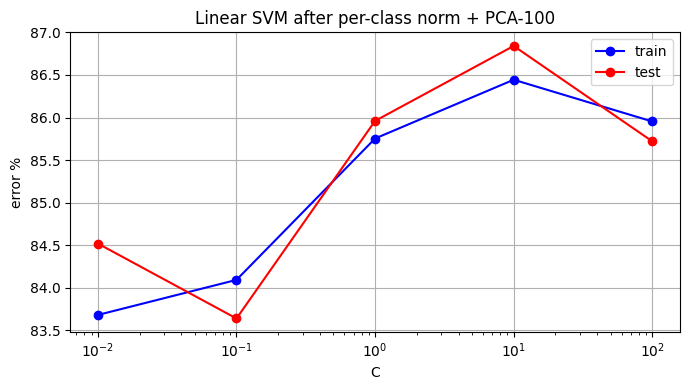


Quadratic kernel SVM  (C=1)
train err 0.17%   test err 2.13%   SVs 17906   time 2.2 min


In [4]:
# -------------------------------------------------------------
# Multiclass kernel + linear SVM on MNIST
# • per-class Z-score normalisation
# • PCA-100   • LinearSVC over C-grid   • Quadratic kernel SVM
# -------------------------------------------------------------
import time, gzip, numpy as np, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm          import LinearSVC, SVC
from sklearn.metrics      import accuracy_score

# ----------  helpers to load gzipped IDX files ----------------

def load_mnist_images(path):
    with gzip.open(path, "rb") as f:
        magic   = int.from_bytes(f.read(4), "big")   # 0x00000803
        n_imgs  = int.from_bytes(f.read(4), "big")
        rows    = int.from_bytes(f.read(4), "big")
        cols    = int.from_bytes(f.read(4), "big")
        data    = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(n_imgs, rows * cols).astype(np.float32) / 255.0

def load_mnist_labels(path):
    with gzip.open(path, "rb") as f:
        magic  = int.from_bytes(f.read(4), "big")    # 0x00000801
        n_lab  = int.from_bytes(f.read(4), "big")
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels.astype(int)

# ----------  1. Load raw data ---------------------------------
train_X = load_mnist_images("train-images-idx3-ubyte.gz")
train_y = load_mnist_labels("train-labels-idx1-ubyte.gz")
test_X  = load_mnist_images("t10k-images-idx3-ubyte.gz")
test_y  = load_mnist_labels("t10k-labels-idx1-ubyte.gz")
print("Raw train:", train_X.shape, " test:", test_X.shape)

# ---------- 2. Per-class Z-score normalisation  ---------------
def per_class_standardize(X, y):
    """Return Z-scored copy of X and dictionaries of per-class mean/std."""
    Xn   = np.empty_like(X)
    mean = {}
    std  = {}
    for cls in np.unique(y):
        idx       = (y == cls)
        mu        = X[idx].mean(axis=0)
        sigma     = X[idx].std(axis=0)
        sigma[sigma == 0] = 1.0      # avoid divide-by-zero
        Xn[idx]   = (X[idx] - mu) / sigma
        mean[cls] = mu
        std[cls]  = sigma
    return Xn, mean, std

def apply_class_standardize(X, y, mean_dict, std_dict):
    Xn = np.empty_like(X)
    for cls in np.unique(y):
        idx     = (y == cls)
        Xn[idx] = (X[idx] - mean_dict[cls]) / std_dict[cls]
    return Xn

train_X, mu_c, std_c = per_class_standardize(train_X, train_y)
test_X  = apply_class_standardize(test_X,  test_y, mu_c, std_c)

# ---------- 3. PCA → 100 dims  (randomised solver) ------------
pca = PCA(n_components=100, svd_solver="randomized", random_state=42)
train_X = pca.fit_transform(train_X)
test_X  = pca.transform(test_X)
print("After PCA:", train_X.shape)

# ---------- 4. Linear SVM grid over C -------------------------
C_grid = [0.01, 0.1, 1.0, 10.0, 100.0]
print("\nLinear SVM (hinge loss, dual=False)")
print(f"{'C':<8}{'train %':>10}{'test %':>10}{'time(s)':>10}")
print("-"*38)

lin_results = []
for C in C_grid:
    t0  = time.time()
    #clf = LinearSVC(C=C, loss="hinge", max_iter=20_000,random_state=42)
    from sklearn.linear_model import SGDClassifier
    clf = SGDClassifier(loss="hinge", alpha=1/(C*len(train_X)),
                    learning_rate="optimal", n_jobs=-1,
                    max_iter=15, tol=1e-3, random_state=42)
    clf.fit(train_X, train_y)
    dt  = time.time() - t0
    tr_err = 100 - 100*clf.score(train_X, train_y)
    te_err = 100 - 100*clf.score(test_X,  test_y)
    lin_results.append((C, tr_err, te_err))
    print(f"{C:<8}{tr_err:>10.2f}{te_err:>10.2f}{dt:>10.2f}")

# ---------- 5. Plot learning curve ----------------------------
plt.figure(figsize=(7,4))
plt.plot(C_grid, [r[1] for r in lin_results], "bo-", label="train")
plt.plot(C_grid, [r[2] for r in lin_results], "ro-", label="test")
plt.xscale("log"); plt.xlabel("C"); plt.ylabel("error %")
plt.title("Linear SVM after per-class norm + PCA-100")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig("linear_svm_curve.png", dpi=300); plt.show()

# ---------- 6. Quadratic kernel SVM (degree-2) ----------------
print("\nQuadratic kernel SVM  (C=1)")
t0 = time.time()
quad = SVC(C=1.0, kernel="poly", degree=2, coef0=1.0,
           gamma="scale", random_state=42)
quad.fit(train_X, train_y)
qt   = time.time() - t0
tr_q = 100 - 100*quad.score(train_X, train_y)
te_q = 100 - 100*quad.score(test_X,  test_y)
print(f"train err {tr_q:.2f}%   test err {te_q:.2f}%   "
      f"SVs {quad.n_support_.sum()}   time {qt/60:.1f} min")
